## Air.csv collector in one file
- 
- 

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = os.path.join(os.getcwd(),'static', 'data')
all_files = glob.glob(os.path.join(data_path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

_list = []
for _file in all_files:
    _df = pd.read_csv(_file, index_col='TIMES', header=0)
    _list.append(_df)

In [3]:
df = pd.concat(_list, axis=0, ignore_index=False)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 2019.01/06(Sun)-01:00 to 2019.01/07(Mon)-15:00
Data columns (total 7 columns):
Time     177 non-null object
SO2      177 non-null float64
NO2      177 non-null float64
O3       177 non-null float64
CO       177 non-null float64
PM10     177 non-null int64
PM2.5    177 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 11.1+ KB


In [4]:
print(df.shape)
df.head()

(177, 7)


,Time,SO2,NO2,O3,CO,PM10,PM2.5
TIMES,,,,,,,
2019.01/06(Sun)-01:00,2019-01-06 01:00:00,0.007,0.024,0.016,0.7,52,19
2019.01/06(Sun)-02:00,2019-01-06 02:00:00,0.009,0.025,0.015,0.6,53,20
2019.01/06(Sun)-03:00,2019-01-06 03:00:00,0.009,0.023,0.017,0.7,56,23
2019.01/06(Sun)-04:00,2019-01-06 04:00:00,0.008,0.020,0.020,0.6,59,23
2019.01/06(Sun)-05:00,2019-01-06 05:00:00,0.008,0.023,0.017,0.6,59,26


## 단계별 변환을 한번에 바꿈
- dfd = **df.drop_duplicates**(subset='TIMES', keep='first') # ... (128, 11)
 > 1. dfs = **dfd.set_index**('TIMES')    
 >    파생변수: TIMES ... 오름/내림차순 정리가 쉽다 (언제든 다시 만들수 있다.) ... O
 > 1. dfs = **dfd.sort_values**(by=['TIMES'], ascending=1, axis=0)    
 >    **PLOT** 을 할때 인덱스를 따라가기 때문에, 인덱스 정렬이 필요하다 .... NG
- dfn = **dfs.filter**(items=['TIMES', 'Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'])

In [5]:
# dfd = df.drop_duplicates(subset='TIMES', keep='first')
# dfd.shape                      # (128, 11)
# dfs = dfd.sort_values(by=['TIMES'], ascending=1, axis=0)
# dfn = dfs.filter(items=['TIMES', 'Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'])


dfn = df.drop_duplicates(
            # subset='TIMES',      # TIMES 가 인덱스로 걸려서, 활용불가!
            subset='Time', 
            keep='first',
        )\
    .sort_values(
            by=['TIMES'], 
            ascending=1, 
            axis=0,
        )


#     .filter(
#         items=[
#             'TIMES', 
#             'Time', 
#             'SO2', 
#             'NO2', 
#             'O3', 
#             'CO', 
#             'PM10', 
#             'PM2.5'],
#         )\

#     .set_index('TIMES')

# dfn.info()

In [6]:
dfn.head()

,Time,SO2,NO2,O3,CO,PM10,PM2.5
TIMES,,,,,,,
2019.01/02(Wed)-01:00,2019-01-02 1:00,0.006,0.017,0.025,0.5,30,18
2019.01/02(Wed)-02:00,2019-01-02 2:00,0.006,0.018,0.025,0.5,30,18
2019.01/02(Wed)-03:00,2019-01-02 3:00,0.006,0.028,0.015,0.6,35,22
2019.01/02(Wed)-04:00,2019-01-02 4:00,0.005,0.039,0.005,0.7,40,26
2019.01/02(Wed)-05:00,2019-01-02 5:00,0.005,0.039,0.005,0.7,43,28


In [7]:
dfn.tail()

,Time,SO2,NO2,O3,CO,PM10,PM2.5
TIMES,,,,,,,
2019.01/07(Mon)-14:00,2019-01-07 14:00:00,0.009,0.028,0.023,0.9,59,39
2019.01/07(Mon)-15:00,2019-01-07 15:00:00,0.010,0.029,0.024,0.8,55,33
2019.01/07(Mon)-16:00,2019-01-07 16:00:00,0.009,0.021,0.033,0.9,56,35
2019.01/07(Mon)-17:00,2019-01-07 17:00:00,0.008,0.022,0.033,0.9,54,35
2019.01/07(Mon)-18:00,2019-01-07 18:00:00,0.008,0.024,0.030,0.9,57,35


In [8]:
os.getcwd()

'C:\\Users\\nitt0\\Documents\\Github\\web_beautifulsoup_scrapping\\jupyter_air'

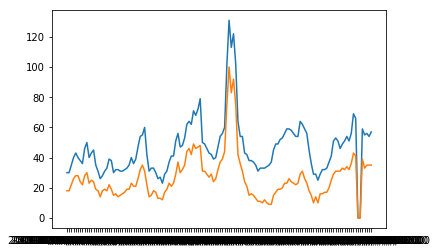

In [9]:
plt.plot(dfn['PM10'])
plt.plot(dfn['PM2.5'])

# img_name = 'foo_bar_foo.png'
# plt.savefig('./static/img/test/' + img_name)

plt.show()

In [10]:
NOW_DATE = dfn.index[-1]    # '2019.01/06(Sun)-16:00'
print(f"The Last ... {NOW_DATE} \n")


YEAR = NOW_DATE[:4]
MONTH= NOW_DATE[5:7]
DAY  = NOW_DATE[8:10]
WEEK = NOW_DATE[11:14]
HOUR = NOW_DATE[-5:-3]
SAVE_LOG = f"{YEAR}{MONTH}{DAY}_{WEEK}_{HOUR}00"

print(f"마지막 기록 = {YEAR}년 {MONTH}월 {DAY}일 ({WEEK}) {HOUR}:00")
print(SAVE_LOG)

The Last ... 2019.01/07(Mon)-18:00 

마지막 기록 = 2019년 01월 07일 (Mon) 18:00
20190107_Mon_1800


In [11]:
os.path.join(data_path)

'C:\\Users\\nitt0\\Documents\\Github\\web_beautifulsoup_scrapping\\jupyter_air\\static\\data'

In [12]:
# Data Frame 을 엑셀로 저장한다. (CSV화일)
file_name = f"_air_{SAVE_LOG}.csv"
dfn.to_csv(os.path.join(data_path, file_name), sep=',', encoding='utf-8')